In [1]:
from __future__ import print_function, division
import scipy
from keras.models import load_model
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from tqdm import tqdm
import keras
import pandas as pd
from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import cv2
import helpers

#Root directory of the project
ROOT_DIR = os.path.abspath(".")
# Training file directory
DATASET = os.path.join(ROOT_DIR, 'dataset')

PATH = "{}/{}".format(DATASET, "isic2016numpy")
PATH

Using TensorFlow backend.


'C:\\Users\\Hasib\\Desktop\\works\\lesion-learnt\\dataset/isic2016numpy'

In [2]:
# load data
x_train = np.load("{}/x_train.npy".format(PATH))
y_train = np.load("{}/y_train.npy".format(PATH))
x_train.shape, y_train.shape

((900, 256, 256, 3), (900, 2))

In [3]:
MODEL_PATH = os.path.join(ROOT_DIR, "models")

model = load_model(os.path.join(MODEL_PATH, 'generator_200.h5'), custom_objects={'InstanceNormalization':InstanceNormalization})
model.summary()

C:\Users\Hasib\Anaconda3\envs\skin\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 128, 128, 32) 1568        input_27[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_73 (LeakyReLU)      (None, 128, 128, 32) 0           conv2d_115[0][0]                 
__________________________________________________________________________________________________
instance_normalization_87 (Inst (None, 128, 128, 32) 2           leaky_re_lu_73[0][0]             
___________________________________________________________________________________________

In [13]:
def predict(model, img):
    
    if img.shape[0] != 256:
        print("Resizing image..")
        img = cv2.resize(img, (256, 256))

    img = img/127.5 - 1.
    img = np.expand_dims(img, axis=0)
    img = model.predict(img)
    img = np.squeeze(img, axis=0)
    img = 0.5 * img + 0.5
    return img


def oversample(x, y, model):
    '''
    Some cool stuff
    INPUT
        x: 
        y:
        model:
        
    OUTPUT
        New folder in the current directory.
    '''
    
    print("Before oversampling :", x.shape, y.shape)
    
    # majority class
    majority_samples = []
    for img, label in zip(x, y):
        if label[1] == 0:
            majority_samples.append(img)
        else:
            pass
    
    # numpy array of majority classes
    majority_samples = np.array(majority_samples)
    
    # minority generated samples
    synthetic_samples = []
    
    # iterate over majority samples and generate minority class
    for img in tqdm(majority_samples):
        
        # translate to malignant
        pred = predict(model, img)
        synthetic_samples.append(pred)
    
    # make labels for generated minority classes
    y_syn = np.array([1 for _ in range(len(synthetic_samples))])
    y_syn = np_utils.to_categorical(y_syn, 2)
    
    # use standard preprocessing
    x = x.astype('float32')
    x /= 255
    
    # merge and shuffle training and generated samples
    x_balanced = np.concatenate( (x, synthetic_samples), axis = 0)
    y_balanced = np.concatenate( (y, y_syn), axis = 0)
    x_balanced, y_balanced = helpers.shuffle_dataset(x_balanced, y_balanced)
    
    
    assert len(majority_samples) == len(synthetic_samples), "This should be same! If not, check model code"
    assert len(x_balanced) == len(synthetic_samples) + len(x_train), "Check oversampler code"
    print("After oversampling: ", x_balanced.shape, y_balanced.shape)
    
    return majority_samples, synthetic_samples, x_balanced, y_balanced


In [14]:
raw, gen, x_new, y_new = oversample(x_train, y_train, model)

Before oversampling : (900, 256, 256, 3) (900, 2)


100%|████████████████████████████████████████| 727/727 [00:53<00:00, 13.54it/s]


Shuffling data
After oversampling:  (1627, 256, 256, 3) (1627, 2)


In [15]:
# use standard preprocessing
x_train_pre = x_train.astype('float32')
x_train_pre /= 255

0.039215688 0.6666667


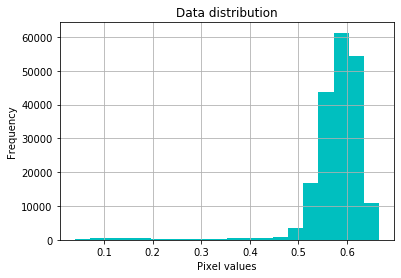

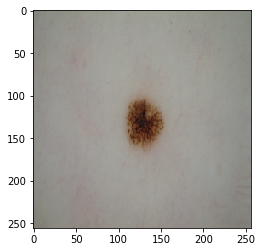

In [27]:
ct = 655
img = x_train[ct]
helpers.plot_hist(x_train_pre[ct])
plt.imshow(img)

0.0028923452 0.93872905


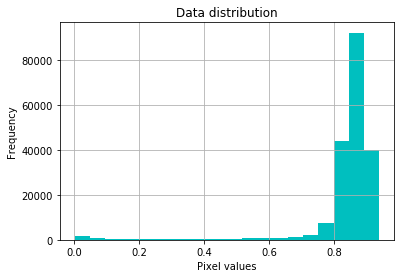

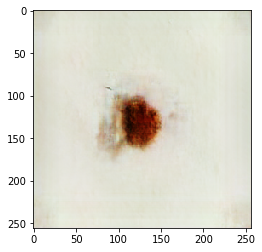

In [28]:
img_g = predict(model, img)
helpers.plot_hist(img_g)
plt.imshow(img_g)

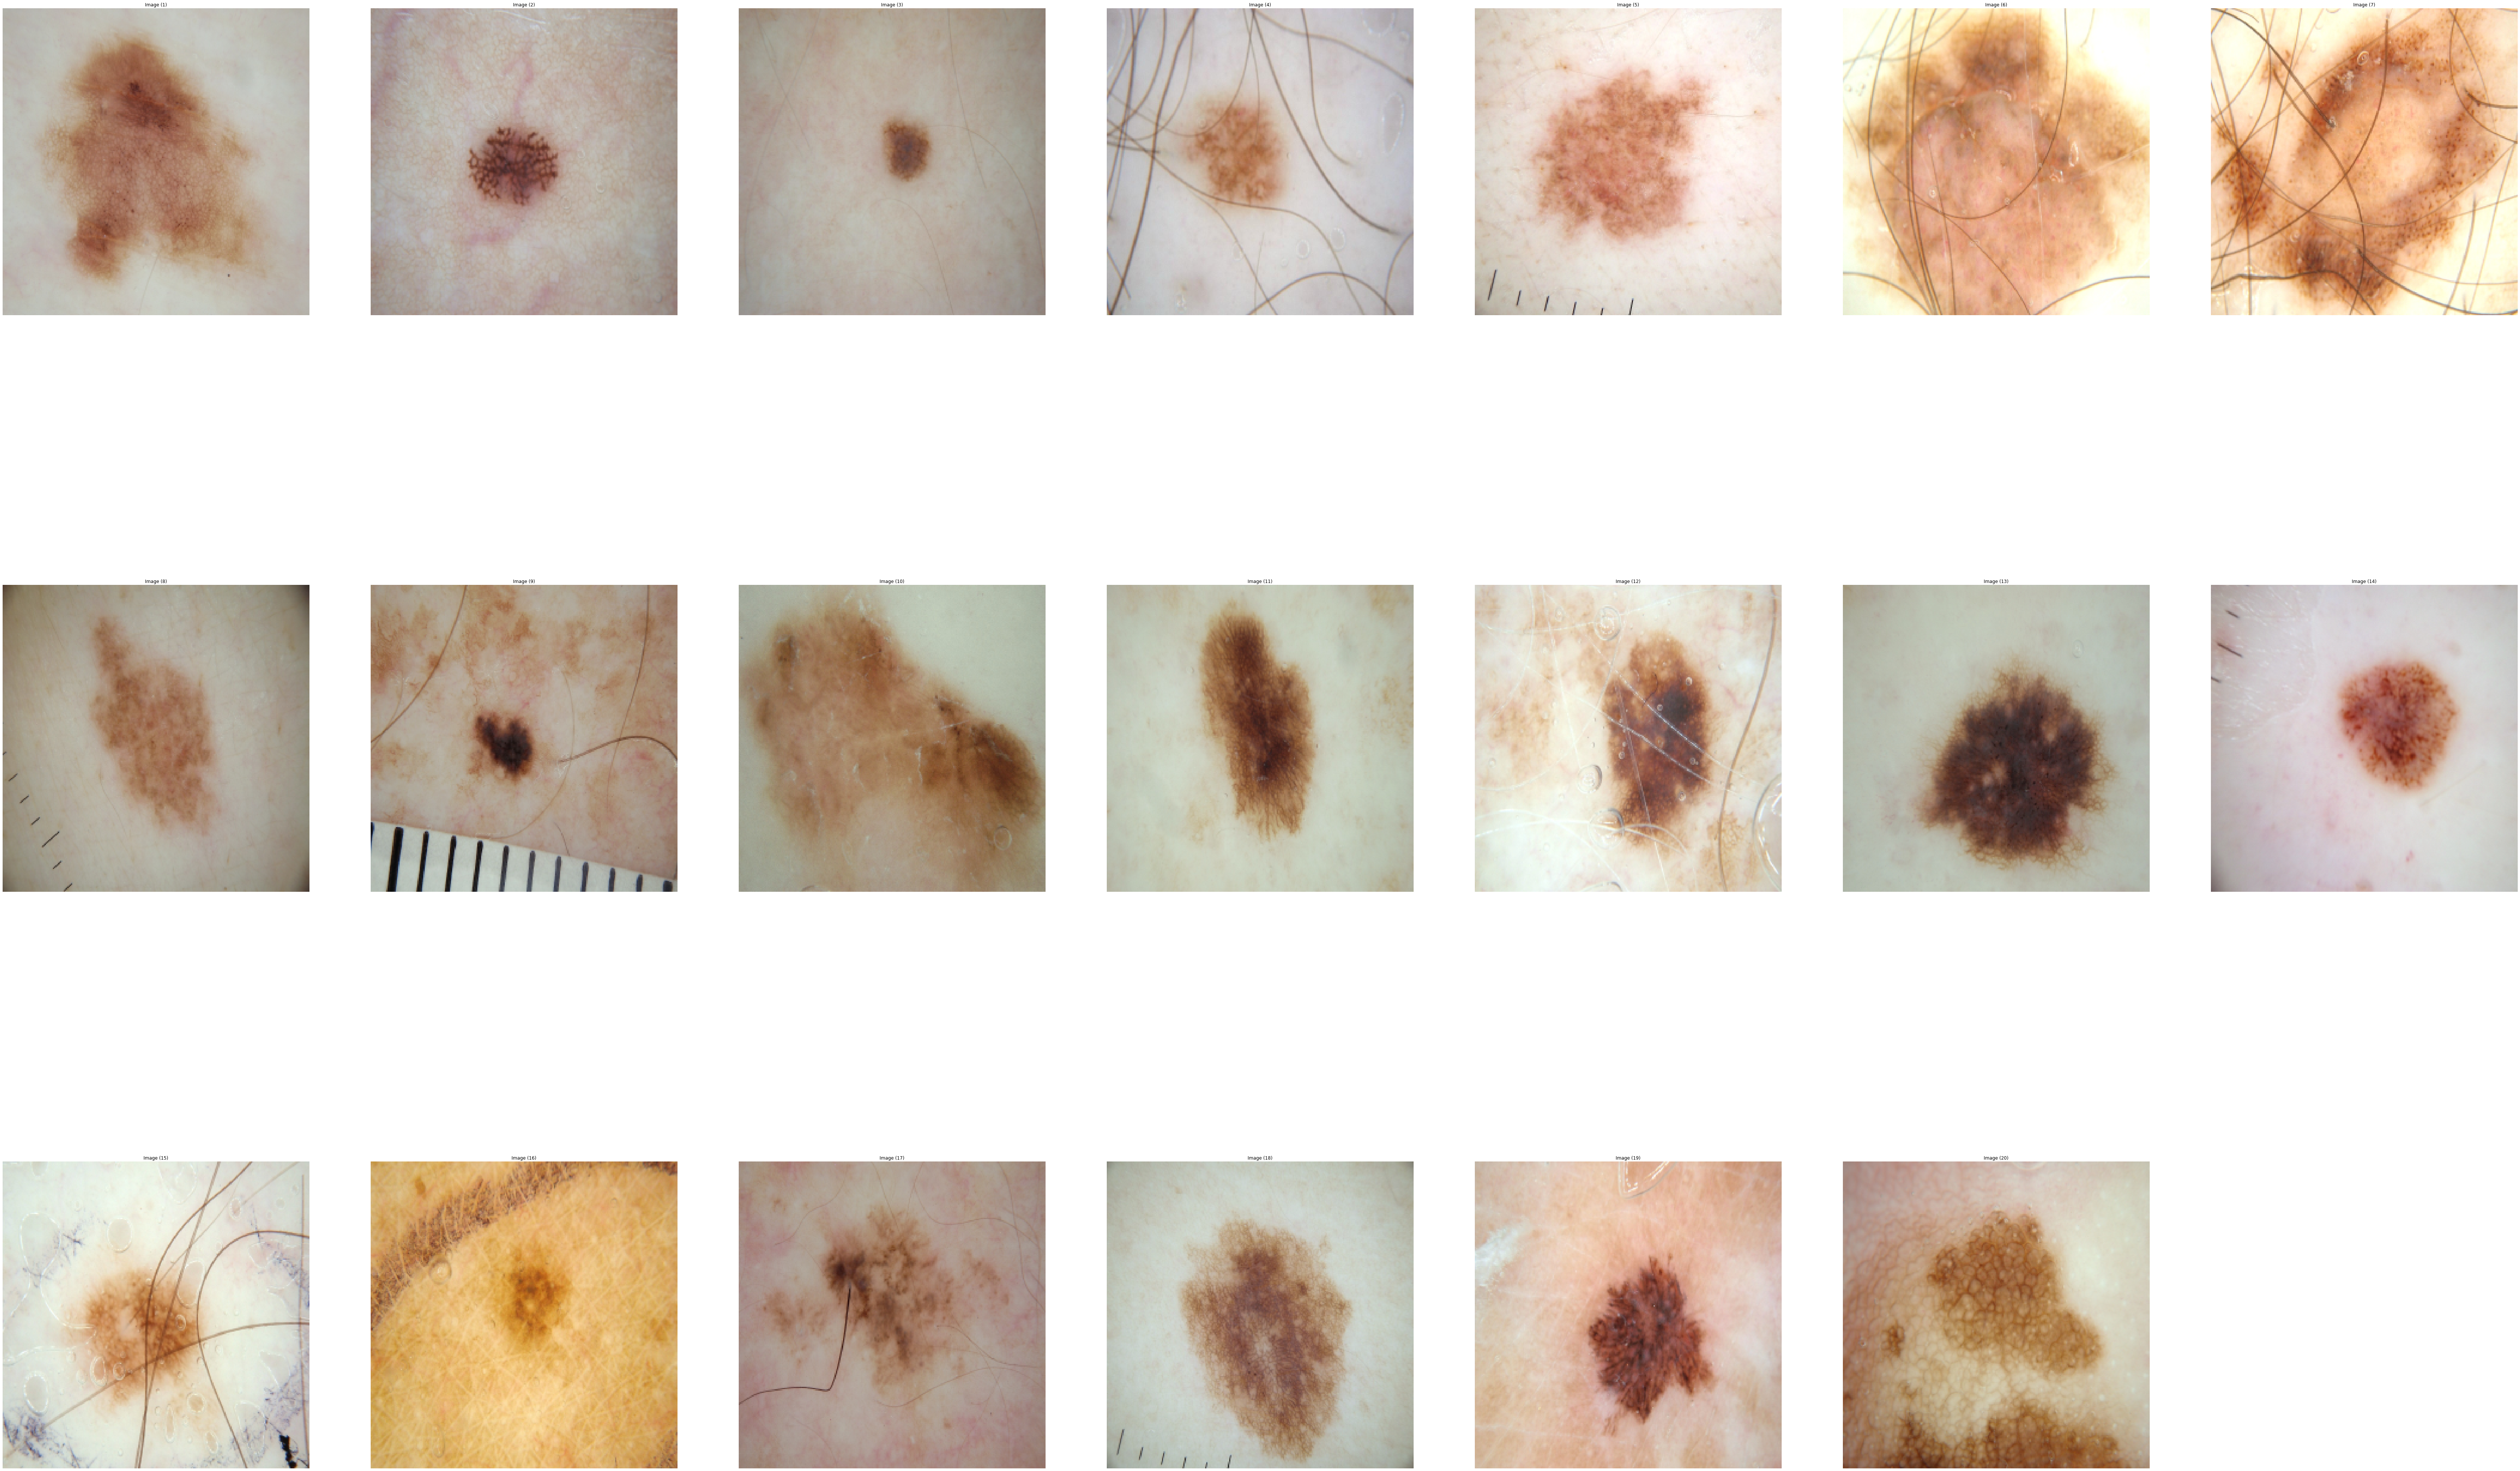

In [33]:
helpers.show_images(raw[-20:], cols = 3, titles = None, save_fig = "default")

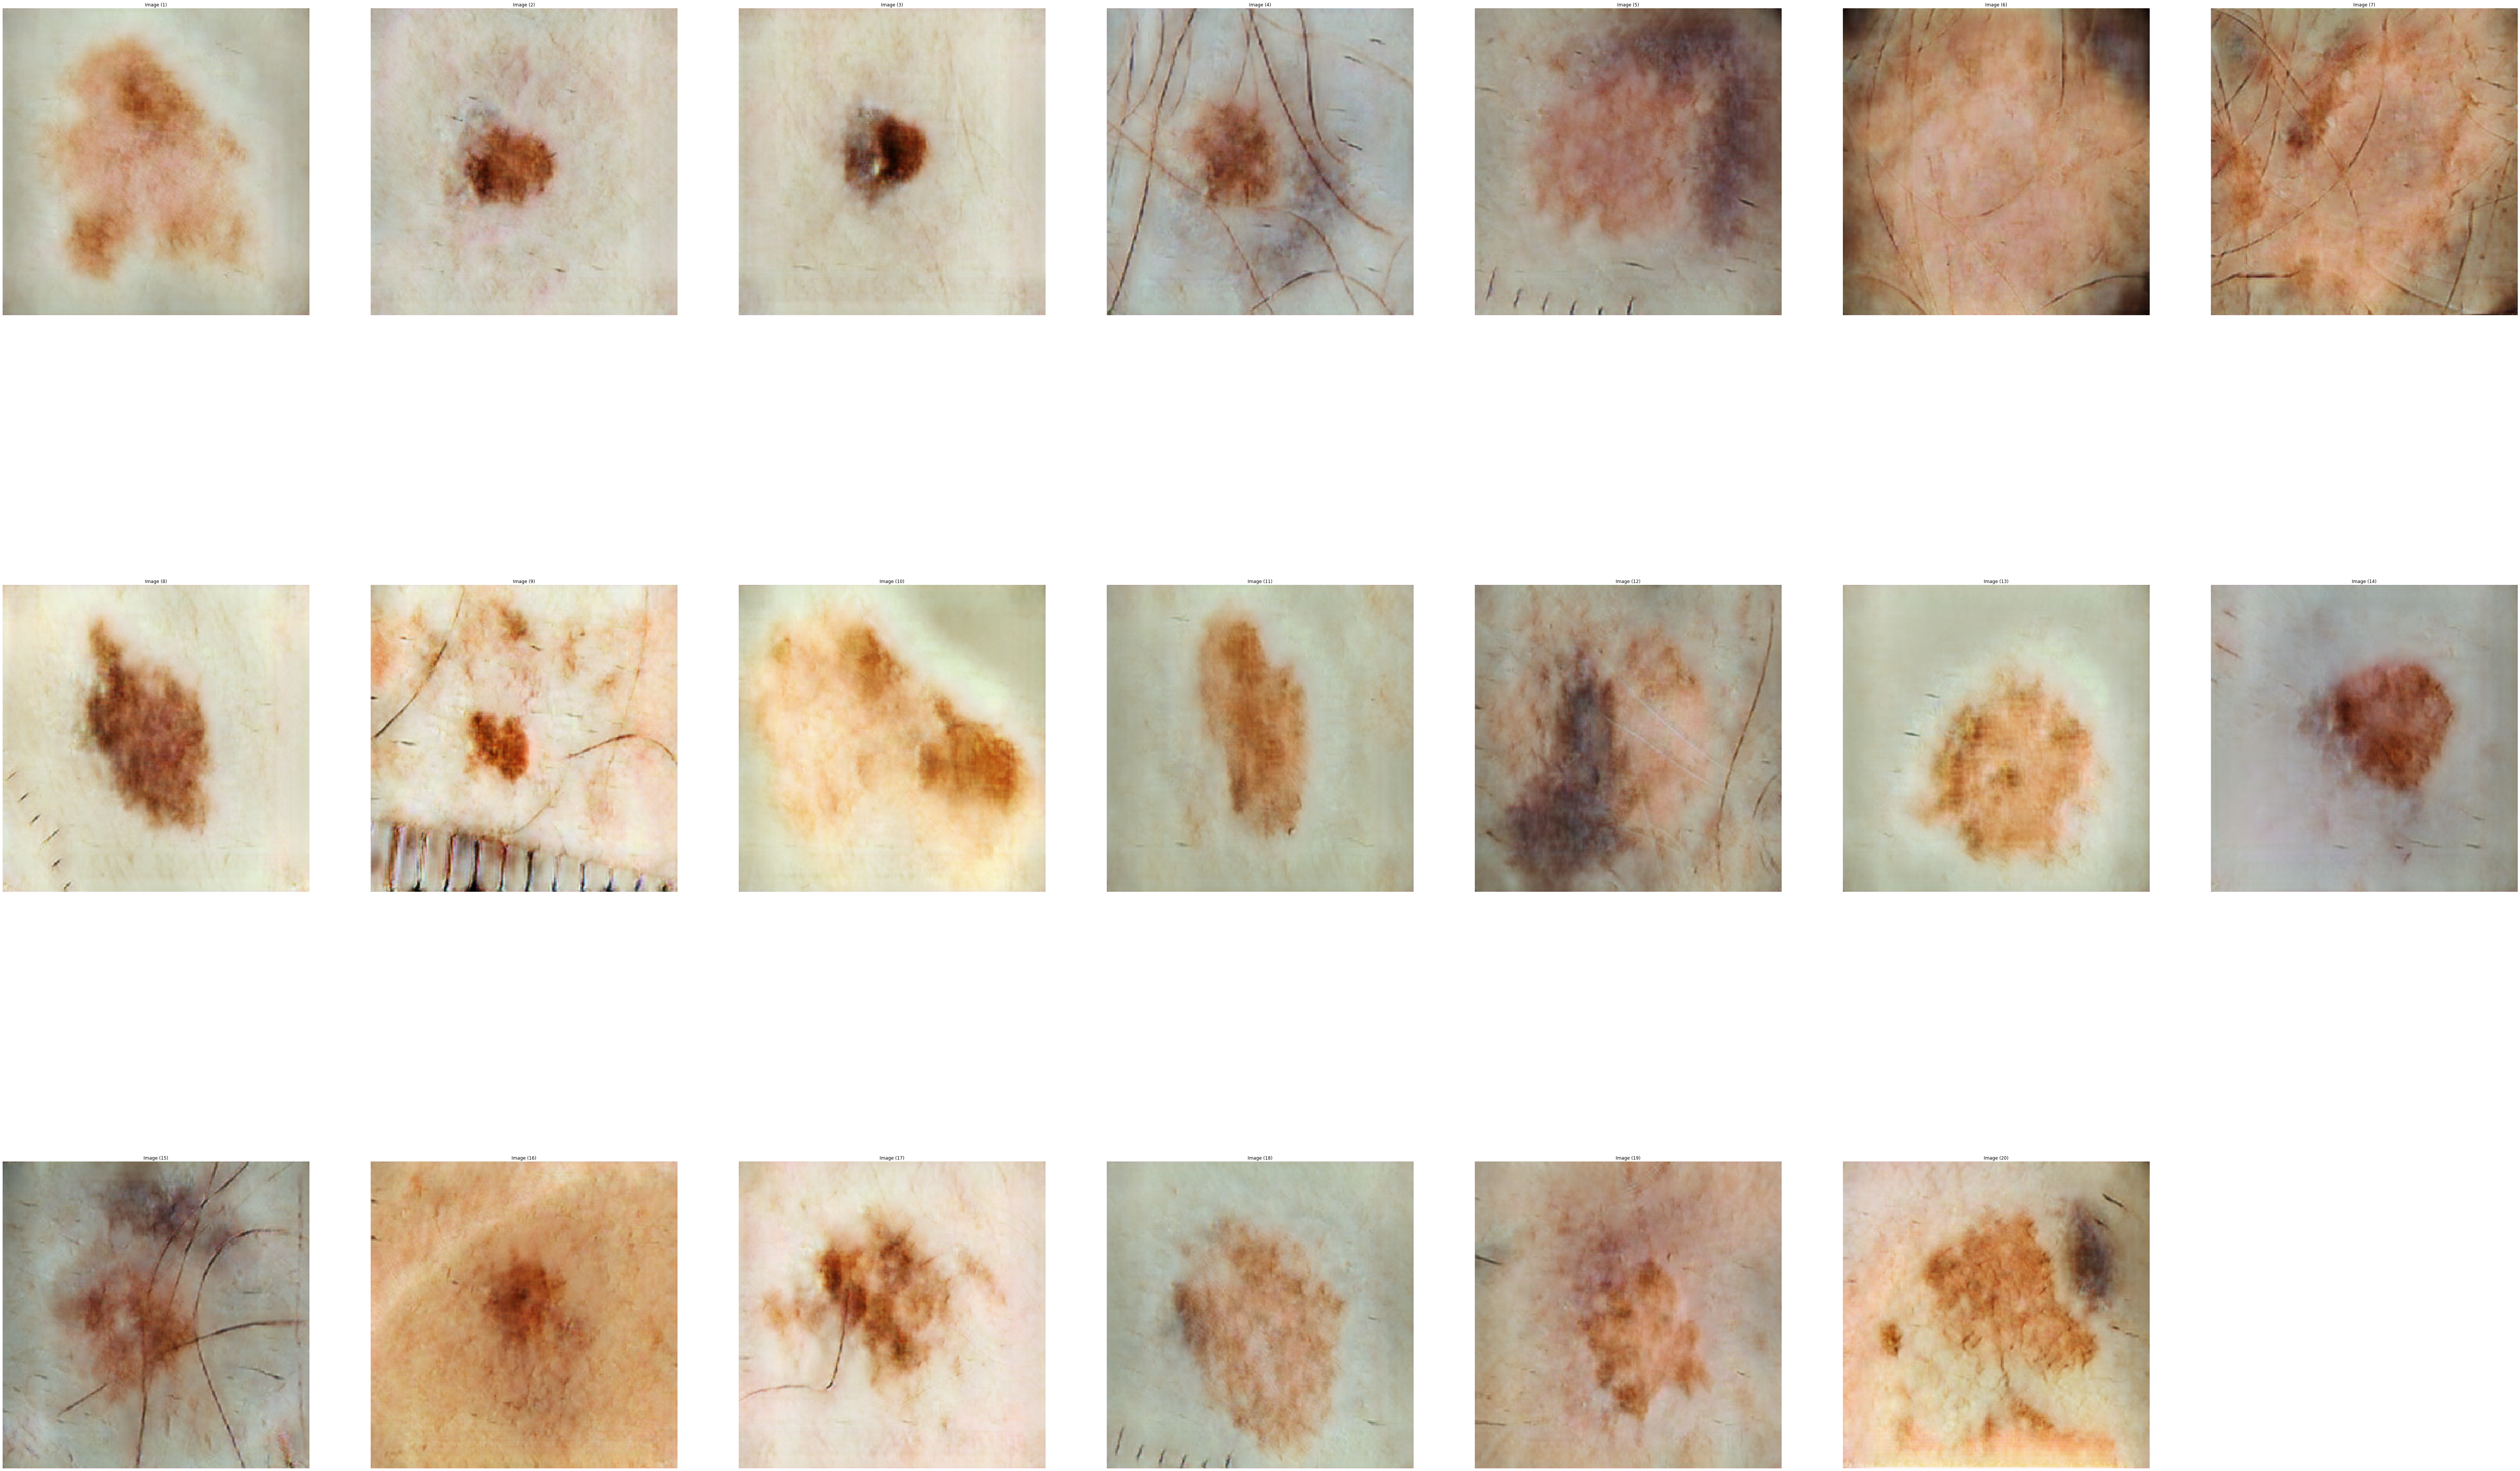

In [34]:
helpers.show_images(gen[-20:], cols = 3, titles = None, save_fig = "default")

In [35]:
a = np.array([np.argmax(y) for y in y_new])
len(a)

1627

In [36]:
np.count_nonzero(a == 0), np.count_nonzero(a == 1)

(727, 900)

In [38]:
# Create directory
helpers.create_directory("dataset/isic2016gan/")

# Save
np.save("dataset/isic2016gan/{}.npy".format("x_gan.npy"), x_new)
np.save("dataset/isic2016gan/{}.npy".format("y_gan.npy"), y_new)